In [23]:
import li.analysis as la
import li.EvaluationHelpers as eh

import os
import numpy as np
import matplotlib.pyplot as plt

# Data Loading and Definition of Variables

In [24]:
# path to images
images_set = "A_810G_Scan_SpeedSound"

path_dir = "Z:/Archiv/2D/Experiment/2024/20241203/Images20241203/" + images_set + "/"
path_file = os.listdir(path_dir)

In [25]:
# grab loop variable names
variables = la.loop_variables(path_dir + path_file[0])[1]
var_vals = la.loop_variables(path_dir + path_file[0])[0]

In [26]:
variables

['i', 'Acc_heat_freq', 'RF23_Sweep_Rate']

In [27]:
# experiment variables loaded from experiment control
info = la.GetImageMetadata(path_dir + "AtomsDarkM_i_1_Acc_heat_freq_0_RF23_Sweep_Rate_30.png")
info_sorted = dict(sorted(info[0].items(), key=lambda x: x[0].lower()))
# info_sorted

# Image Processing

In [28]:
%%time
# create initial dictionary with all raw images
images_raw = eh.createImageInfoList([path_dir], variables)

CPU times: total: 109 ms
Wall time: 668 ms


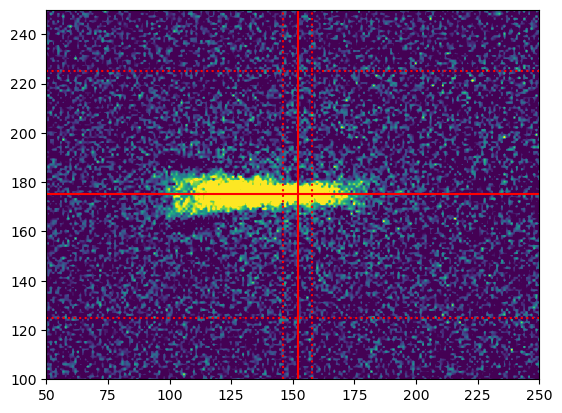

In [29]:
# determine optimal ROI
center = (175, 152)
h = 50
w = 6

single_prc = la.density_builder([images_raw[3]], variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = True)

plt.imshow(single_prc.iloc[0]["density"].data, vmin = 0, vmax = 3, cmap = "viridis")

plt.xlim(50, 250)
plt.ylim(100, 250)


plt.axhline(center[0], c = "red")
plt.axhline(center[0] - h, c = "red", ls = ":")
plt.axhline(center[0] + h, c = "red", ls = ":")

plt.axvline(center[1], c = "red")
plt.axvline(center[1] - w, c = "red", ls = ":")
plt.axvline(center[1] + w, c = "red", ls = ":")


plt.show()

In [30]:
%%time
# calculate all density images and apply mask
images_prc = la.density_builder(images_raw, variables, center, h, w, info_sorted["Csat"], info_sorted["Img_Illumination_Time"], progress_disable = False)

|████████████████████████████████████████| 1300/1300 [100%] in 2:12.3 (9.83/s)  
CPU times: total: 54.5 s
Wall time: 2min 12s


In [31]:
var_vals[2]

array([70., 60., 50., 40., 30., 20.])

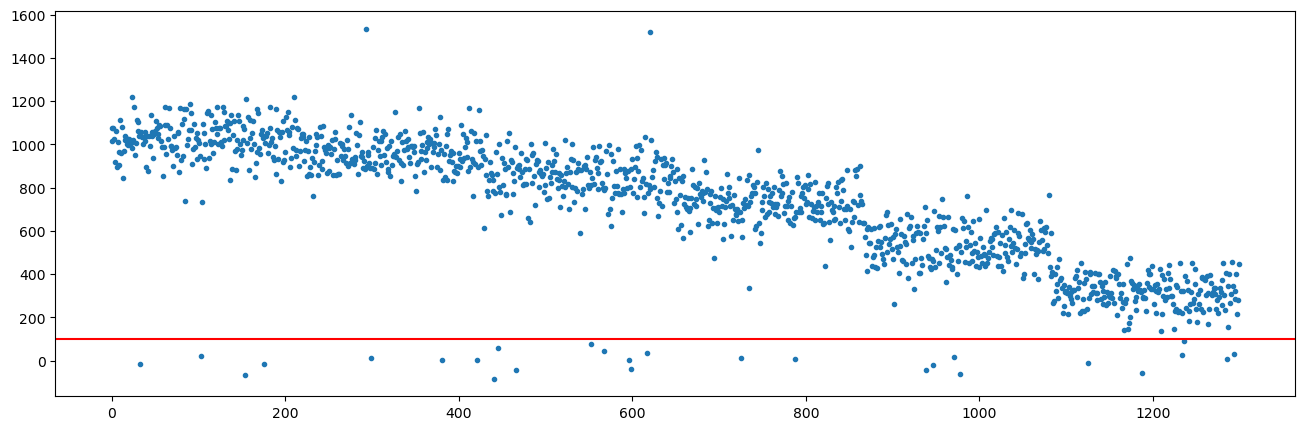

In [32]:
# filter out missed shots
bol = []

for rate in var_vals[2]:

    for i, im in images_prc[images_prc["RF23_Sweep_Rate"] == rate].iterrows():
        bol.append(np.sum(im["density"].compressed()))

plt.figure(figsize = (16, 5))

plt.plot(bol, ".")
plt.axhline(100, c = "r")

plt.ylim(None, None)

plt.show()

In [33]:
%%time
# filter missed shots
images_fil = la.filter(images_prc, 100)

CPU times: total: 156 ms
Wall time: 154 ms


In [34]:
%%time
# group by loop variables and average over iterations
images_grp = la.group(images_fil, variables, "i")

CPU times: total: 2.58 s
Wall time: 2.7 s


In [35]:
%%time
# make T4 fits 
images_fit = la.T4_fit(images_grp)

CPU times: total: 1.94 s
Wall time: 1.98 s


In [36]:
%%time
# calculate response
images_res = la.response(images_fit)

CPU times: total: 0 ns
Wall time: 4.29 ms


# Visualization

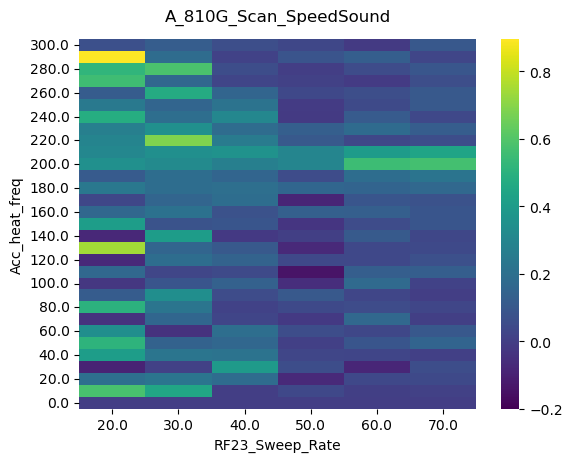

In [37]:
la.visualize(images_res, "Acc_heat_freq", "RF23_Sweep_Rate", "response", images_set, vmin = -0.2, vmax = None)

In [38]:
# heat = images_res.pivot(index="Acc_heat_freq", columns="RF23_Sweep_Rate", values="response")
# heat_run = images_res.pivot(index="Acc_heat_freq", columns="RF23_Sweep_Rate", values="response_run")
#
# plt.plot(heat[70], ".")
# plt.plot(heat_run[70], ".")
#
# plt.ylim(None, 2)
#
# plt.show()

In [39]:
# with alive_bar(100, force_tty=True, spinner = "twirl", disable = True) as bar:
#     for i in range(100):
#         time.sleep(.01)
#         bar()